Deal with unlabeled bbox (remove car IDs)
Goal: associate measurements to unique objects
1. remove car labels
2. formulate MILP

In [2]:
from utils import *
import importlib
import utils
importlib.reload(utils)
import os.path
from os import path
import pandas as pd
import utils_optimization as opt
importlib.reload(opt)
import time
from scipy.optimize import minimize,NonlinearConstraint,leastsq,fmin_slsqp,least_squares
import numpy.linalg as LA


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [12]:
# load data and remove car ID
data_path = pathlib.Path().absolute().joinpath('../2D-3D May 2021')
file_name = data_path.joinpath('record_p2c4_00001_track_outputs_corrected_3D.csv')
df = utils.read_data(file_name,0)

path_vpts = data_path.joinpath('camera_calibration_points_I24_validation_system.csv')
print('Transform from image to gps...')
df = utils.img_to_gps(df, 'P2C4', path_vpts) # transform from pixel to gps coordinates
A = [36.004654, -86.609976] # south west side, so that x, y coords obey counterclockwise
B = [36.002114, -86.607129]
print('Transform from gps to road...')
df = utils.gps_to_road_df(df)
print('Get x direction...')
df = utils.get_x_direction(df)
print('Naive filter...')
df = utils.naive_filter_3D(df)
xmin,xmax,ymin,ymax = utils.get_xy_minmax(df)

# select only the first 200 rows for trial
df = df.head(200)
nO = len(df.groupby('ID'))
df = df.drop(['ID'],axis=1)
print(nO,' unique cars')
df

Transform from image to gps...
Transform from gps to road...
Get x direction...
Naive filter...


C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:182: RuntimeWarning: invalid value encountered in greater
  outliers = np.logical_or(w1>5, w2>5)
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:190: RuntimeWarning: invalid value encountered in greater
  outliers =	abs(l1 - m1) > 2 * s1


4  unique cars


,Frame #,Timestamp,Object class,BBox xmin,BBox ymin,BBox xmax,BBox ymax,vel_x,vel_y,Generation method,...,bbllon,bbr_x,bbr_y,fbr_x,fbr_y,fbl_x,fbl_y,bbl_x,bbl_y,direction
0,65,1.754433e+09,pickup,3484.000000,686.000000,3834.000000,838.000000,-51.490238,9.889586,Manual Annotation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
1,66,NaN,pickup,3424.666667,686.666667,3774.666667,838.000000,-51.490238,9.889586,NaN,...,-86.607575,286.634989,33.297681,280.937256,33.315174,281.069620,31.521108,286.792874,31.566399,-1.0
2,67,NaN,pickup,3365.333333,687.333333,3715.333333,838.000000,-51.490238,9.889586,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
3,68,NaN,pickup,3306.000000,688.000000,3656.000000,838.000000,-51.490238,9.889586,NaN,...,-86.607591,284.394542,33.244571,278.893401,33.323290,280.201705,31.553031,284.629042,31.598340,-1.0
4,69,NaN,pickup,3246.666667,688.666667,3596.666667,838.000000,-51.490238,9.889586,NaN,...,-86.607599,283.446562,33.102469,277.751315,33.177306,277.866267,31.574085,283.530932,31.618767,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,15,1.754432e+09,truck (other),3005.979248,723.948914,3530.973389,956.836914,-53.225006,-2.704681,Localizer,...,-86.607649,280.040131,30.105417,272.654571,30.340267,272.778455,28.264190,280.451496,28.349265,-1.0
196,16,1.754432e+09,truck (other),2945.922607,731.941528,3466.830811,960.118103,-57.118340,0.522501,Localizer,...,-86.607657,278.940889,30.123534,271.557957,30.355503,271.680852,28.280037,279.338385,28.364915,-1.0
197,17,1.754432e+09,truck (other),2879.591064,733.551453,3397.896729,964.419739,-62.469040,0.969154,Localizer,...,-86.607666,277.841768,30.158894,270.462321,30.385313,270.586836,28.275325,278.225928,28.360125,-1.0
198,18,1.754432e+09,truck (other),2811.612061,737.525330,3331.812500,967.110168,-64.608803,1.671608,Detector,...,-86.607673,276.746922,30.121409,269.343920,30.378188,269.462866,28.300981,277.140746,28.386112,-1.0


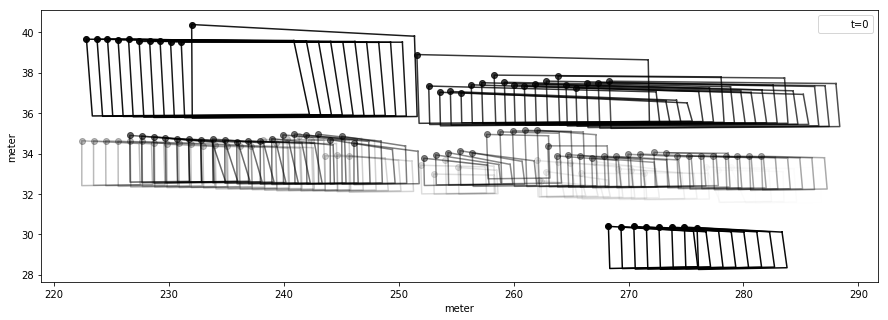

In [15]:
# try known number of objects
# plot 
import utils
importlib.reload(utils)
D = np.array(df[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
utils.plot_track(D,15,5)

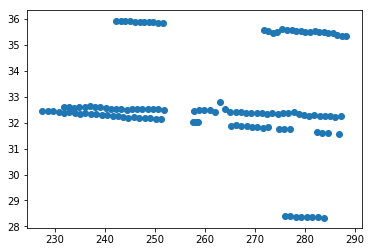

In [16]:
plt.scatter(df['bbl_x'],df['bbl_y'])
plt.show()